#  Modelado de Topics

### Librerías y funciones necesarias

In [1]:
# Librería gensim (complementaria a Spacy)
# Librería pyLDAvis 
!pip install gensim
!pip install pyLDAvis

In [2]:
import random
import pandas as pd
import numpy as np
import os

import gensim
from gensim.corpora import Dictionary  # Diccionario clave:valor
from gensim.models import LdaModel, CoherenceModel  # Modelo LDA

import pyLDAvis  # Visualizar los clusters
import pyLDAvis.gensim
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Sets the value of the specified option
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# Función que realiza comprobaciones sobre una columna de un dataframe
def check_column(df, col_name):
    values_unique = len(df[col_name].unique())
    values_nan = df[col_name].isnull().sum()
    portmissing = round((df[col_name].isnull().sum()/len(df))*100, 4)
    
    print (f'{col_name} consta de: {values_unique} valores distintos de un total de {len(df)}')
    print (f'{col_name} consta de: {values_nan} valores ausentes, {portmissing}%')

### Lectura de datos

In [4]:
# Lectura del dataset con los reviews de amazon descargados en el notebook 0_AnalisisSentimientos_sintratamiento.ipynb
# Son 20000 tweets sobre music, clothing, health and sports con 5000 por subset balanceados por overall de 1 a 5
df_amazon = pd.read_pickle('df_amazoncompleto.pkl')
print(f'Dimensiones del dataset son: {df_amazon.shape}')

Dimensiones del dataset son: (20000, 9)


In [5]:
# Visualizamos las primeras filas
df_amazon.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A319Y60NW7HS77,B000001EGI,"radiogold ""radiogold""","[2, 21]",Tumbleweed Connection raised Elton to his init...,1.0,"Just a brief dip, he would improve again!",1084752000,"05 17, 2004"
1,A15HQSBVCU724Y,B0002XEDSU,Mikky Mouse,"[3, 4]",Im not gonna review on this.. all i can say is...,1.0,That White Tee song is retarded,1134000000,"12 8, 2005"
2,AZ39SOZT3NZQU,B000FVQYYK,XraySpex,"[4, 67]",I bought this album because I went to a lyric ...,1.0,Put This In A Black Hole,1184544000,"07 16, 2007"
3,A36489F4G8T4E7,B000075A20,Edgar Sanchez,"[5, 9]",This poorly made and horrible album is reason ...,1.0,DONT PAY THE COST FOR THIS ...,1064102400,"09 21, 2003"
4,A3NL33GFYHE72V,B0006ZQ9BS,"music fan ""music fan""","[2, 6]",This album was a big disappointment. It doesn...,1.0,NO!!!!,1106092800,"01 19, 2005"


In [6]:
# Análisis de la columna retweet
check_column(df_amazon, 'reviewText')
df_amazon['reviewText'].value_counts().head()

reviewText consta de: 19995 valores distintos de un total de 20000
reviewText consta de: 0 valores ausentes, 0.0%


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                3
This was probably a great watch 4-5 years ago but not anymore...*the light "pales" in comparison to the Timex Indiglo. Also, the light does not stay on when switching modes like the Timex Ironman does*the alarm sound is weak and doesn't have a snooze function*Some of the info on the face is hard to see, esp. the solar charge bank*Mine doesn't seem to synch

In [7]:
# Análisis de la columna overall --> muestra balanceada
check_column(df_amazon, 'overall')
df_amazon['overall'].value_counts().head()

overall consta de: 5 valores distintos de un total de 20000
overall consta de: 0 valores ausentes, 0.0%


5.0    4000
4.0    4000
3.0    4000
2.0    4000
1.0    4000
Name: overall, dtype: int64

In [8]:
# Nos quedamos únicamente con la columna reviewText correspondiente al review de los df de Amazon
df_amazon = df_amazon[['reviewText']]
print(f'Dimensiones del dataset son: {df_amazon.shape}')
# No es necesario porque dicha columna no contiene valores ausentes pero lo contemplo 
# para futuros procesados de otros datasets que si contengan valores ausentes.
df_amazon.dropna(inplace=True)
print(f'Dimensiones del dataset son: {df_amazon.shape}')

Dimensiones del dataset son: (20000, 1)
Dimensiones del dataset son: (20000, 1)


In [9]:
# Columnas del df
df_amazon.columns

Index(['reviewText'], dtype='object')

In [10]:
# Visualizamos las primeras filas y observamos que los índices corresponden a la selección aleatoria anterior
df_amazon.head(3)

,reviewText
0,Tumbleweed Connection raised Elton to his init...
1,Im not gonna review on this.. all i can say is...
2,I bought this album because I went to a lyric ...


### Lemmatization (sobre el df completo)

Técnica de normalización de textos que busca reducir las palabras a su raíz (lemma) 

In [11]:
# Ruta del fichero en la que se encuentra el fichero para lemmatización en inglés
# Descargado de la URL https://github.com/michmech/lemmatization-lists
data_path = '../data'
lemmas_dict_file = 'lemmatization-en.txt'

In [12]:
# Función get_lemmas_dict 
def get_lemmas_dict(data_path, lemmas_dict_file):
    lemmas_dict = {}
    with open(os.path.join(data_path, lemmas_dict_file), 'r', encoding='utf-8') as f: 
        for line in f:
            (key, val) = line.split()
            lemmas_dict[str(val)] = key
    return lemmas_dict

In [13]:
# Obtenemos el diccionario de lemmas en inglés
lemmas_dict = get_lemmas_dict(data_path, lemmas_dict_file)
lemmas_dict

{'first': '\ufeff1',
 'tenth': '10',
 'hundredth': '100',
 'thousandth': '1000',
 'millionth': '1000000',
 'billionth': '1000000000',
 'eleventh': '11',
 'twelfth': '12',
 'thirteenth': '13',
 'fourteenth': '14',
 'fifteenth': '15',
 'sixteenth': '16',
 'seventeenth': '17',
 'eighteenth': '18',
 'nineteenth': '19',
 'second': '2',
 'twentieth': '20',
 'two-hundredth': '200',
 'twenty-first': '21',
 'twenty-second': '22',
 'twenty-third': '23',
 'twenty-fourth': '24',
 'twenty-fifth': '25',
 'twenty-sixth': '26',
 'twenty-seventh': '27',
 'twenty-eighth': '28',
 'twenty-ninth': '29',
 'third': '3',
 'thirtieth': '30',
 'three-hundredth': '300',
 'thirty-first': '31',
 'thirty-second': '32',
 'thirty-third': '33',
 'thirty-fourth': '34',
 'thirty-fifth': '35',
 'thirty-sixth': '36',
 'thirty-seventh': '37',
 'thirty-eighth': '38',
 'thirty-ninth': '39',
 'fourth': '4',
 'fortieth': '40',
 'four-hundredth': '400',
 'forty-first': '41',
 'forty-second': '42',
 'forty-third': '43',
 'forty-

In [14]:
# Comprobamos el par token-lemma con el primer registro
print('{0:15}{1:10}'.format('Token' ,'Lemma'))
for word in df_amazon['reviewText'][25].split():
    print('{0:15}{1:10}'.format(word, lemmas_dict.get(word, word)))

Token          Lemma     
Lisa           Lisa      
Loeb           Loeb      
luck           luck      
change         change    
when           when      
friend         friend    
Ethan          Ethan     
Hawke          Hawke     
suggested      suggest   
that           that      
her            her       
cheesy         cheesy    
track          track     
STAY           STAY      
should         should    
become         become    
the            the       
leading        lead      
single         single    
for            for       
the            the       
soundtrack     soundtrack
of             of        
REALITY        REALITY   
BITES          BITES     
back           back      
in             in        
1994.          1994.     
The            The       
corny          corny     
track          track     
rocketed       rocket    
to             to        
#1             #1        
and            and       
Loeb           Loeb      
was            be        
the         

In [15]:
# Aplicamos la lemmatización sobre el df df_amazon 
df_amazon['reviewText']= df_amazon['reviewText'].apply(lambda x: ' '.join([lemmas_dict.get(word, word) for word in x.split()]))

### Preprocesado

Aplicamos gensim.utils.simple_preprocess: Convert a document into a list of lowercase tokens, 

     ignoring tokens that are too short or too long.
     doc : str.     Input document.
     deacc : bool, optional.     Remove accent marks from tokens using :func:`~gensim.utils.deaccent`?
     min_len : int, optional.    Minimum length of token (inclusive). Shorter tokens are discarded.
     max_len : int, optional.    Maximum length of token in result (inclusive). Longer tokens are discarded.

In [16]:
# Función que realiza el preprocesado utilizando las librerías de gensim.utils.simple_preprocess
def text_preprocessing(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

In [17]:
print('Original text:\n{}\n\n'.format(df_amazon['reviewText'][2]))
print('Processed text:\n{}'.format(text_preprocessing(df_amazon['reviewText'][2])))

Original text:
I buy this album because I go to a lyric site and their lyric for a song on Absolution be insightful. Once I receive the album I be consume with disappointment. This world be suffer from the disease of delusion, religion be the opiate of the masses, and it be much destructive than heroin. The ignorance of musician spout their idiotic rhetoric, which perpetuate the myth that god exist and we have soul be sickening. Lyrics be a main component of music and musician have to write lyric that people can relate to in order to provide catharsis. Hopefully this band will cease to exist so intelligent artist will thrive in our culture and challenge the ignorance that infect everything.


Processed text:
['album', 'lyric', 'site', 'lyric', 'song', 'absolution', 'insightful', 'receive', 'album', 'consume', 'disappointment', 'world', 'suffer', 'disease', 'delusion', 'religion', 'opiate', 'masses', 'destructive', 'heroin', 'ignorance', 'musician', 'spout', 'idiotic', 'rhetoric', 'perp

In [18]:
# lista de lista de documentos
processed_texts = []
for text in df_amazon['reviewText']:
    processed_texts.append(text_preprocessing(text))

In [19]:
# Dimensiones del procesado de textos
len(processed_texts)

20000

In [20]:
# processed_texts[2] = text_preprocessing(df['text'][2])
print(processed_texts[2], '\n')
print('Original text:\n{}\n\n'.format(df_amazon['reviewText'][2]))
print('Processed text:\n{}'.format(text_preprocessing(df_amazon['reviewText'][2])))

['album', 'lyric', 'site', 'lyric', 'song', 'absolution', 'insightful', 'receive', 'album', 'consume', 'disappointment', 'world', 'suffer', 'disease', 'delusion', 'religion', 'opiate', 'masses', 'destructive', 'heroin', 'ignorance', 'musician', 'spout', 'idiotic', 'rhetoric', 'perpetuate', 'myth', 'exist', 'soul', 'sickening', 'lyrics', 'main', 'component', 'music', 'musician', 'write', 'lyric', 'people', 'relate', 'order', 'provide', 'catharsis', 'hopefully', 'band', 'cease', 'exist', 'intelligent', 'artist', 'thrive', 'culture', 'challenge', 'ignorance', 'infect'] 

Original text:
I buy this album because I go to a lyric site and their lyric for a song on Absolution be insightful. Once I receive the album I be consume with disappointment. This world be suffer from the disease of delusion, religion be the opiate of the masses, and it be much destructive than heroin. The ignorance of musician spout their idiotic rhetoric, which perpetuate the myth that god exist and we have soul be sic

In [21]:
processed_texts[2] == text_preprocessing(df_amazon['reviewText'][2])

True

### Diccionario 

In [22]:
# Función que genera un diccionario id-palabra a partir de unos textos
def get_dictionary (texts) :
    # turn our tokenized documents into a id <-> term dictionary
    dictionary = Dictionary (texts)
    # dictionary . filter_extremes ( no_below =20 , no_above =0.5)
    # remove_n = 5 means number of the most frequent tokens that will be removed 
    dictionary.filter_n_most_frequent (5)
    return dictionary

In [23]:
# Creación de un diccionario id-palabra
dictionary = get_dictionary(processed_texts)
print(f'Longitud del diccionario: ', {len(dictionary)})

print('Diccionario id,palabra: ')
list(dictionary.items())

Longitud del diccionario:  {40532}
Diccionario id,palabra: 


[(0, 'album'),
 (1, 'ambience'),
 (2, 'audible'),
 (3, 'audibly'),
 (4, 'brick'),
 (5, 'brief'),
 (6, 'bring'),
 (7, 'burn'),
 (8, 'career'),
 (9, 'chateau'),
 (10, 'city'),
 (11, 'clear'),
 (12, 'comfort'),
 (13, 'connection'),
 (14, 'country'),
 (15, 'destroy'),
 (16, 'drown'),
 (17, 'eighteen'),
 (18, 'elton'),
 (19, 'energy'),
 (20, 'epic'),
 (21, 'failure'),
 (22, 'fall'),
 (23, 'honky'),
 (24, 'horrible'),
 (25, 'improve'),
 (26, 'initial'),
 (27, 'inspire'),
 (28, 'instruments'),
 (29, 'john'),
 (30, 'layer'),
 (31, 'legendary'),
 (32, 'listen'),
 (33, 'live'),
 (34, 'long'),
 (35, 'love'),
 (36, 'madman'),
 (37, 'minute'),
 (38, 'mission'),
 (39, 'modestly'),
 (40, 'music'),
 (41, 'noise'),
 (42, 'overdone'),
 (43, 'peak'),
 (44, 'piano'),
 (45, 'player'),
 (46, 'point'),
 (47, 'quot'),
 (48, 'raise'),
 (49, 'rapid'),
 (50, 'reality'),
 (51, 'record'),
 (52, 'release'),
 (53, 'respectively'),
 (54, 'road'),
 (55, 'shoot'),
 (56, 'single'),
 (57, 'steer'),
 (58, 'studios'),
 (59

Como puede observarse las dimensiones del diccionario han aumentado considerablemente con respecto a los notebooks anteriores, en entendible ya que trabajamos con el dataframe completo de 20000 reviews.

### Matriz documento-palabra (ó término)

In [24]:
# Función que genera un corpus dado un diccionario y unos textos
def get_corpus (dictionary, texts) :
    # convert tokenized documents into a document - term matrix
    # doc2bow (document): Convert `document` into the bag-of-words (BoW) format = list of `(token_id, token_count)` tuples.
    corpus = [dictionary.doc2bow(text) for text in texts]
    return corpus

In [25]:
# Creación de un corpus
corpus = get_corpus(dictionary, processed_texts)
print(f'Corpus: ')
corpus

Corpus: 


[[(0, 4),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 2),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 2),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 2),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 2),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 8),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 2),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1)],
 [(0, 2),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1)],
 [(0, 2),
  (40, 1),
  (88, 1)

In [26]:
# Significa que las siguientes palabras o términos con id en el vocabulario se repiten el nº de veces indicado:
# lyrics con id 115 en el diccionario se repite 3 veces
# musicians con id 118 se repite 2 veces
print('Original  text:{}\n'.format(df_amazon['reviewText'][2]))
print('Processed text:{}\n'.format(processed_texts[2]))
print('Corpus        :{}'.format(corpus[2]))


Original  text:I buy this album because I go to a lyric site and their lyric for a song on Absolution be insightful. Once I receive the album I be consume with disappointment. This world be suffer from the disease of delusion, religion be the opiate of the masses, and it be much destructive than heroin. The ignorance of musician spout their idiotic rhetoric, which perpetuate the myth that god exist and we have soul be sickening. Lyrics be a main component of music and musician have to write lyric that people can relate to in order to provide catharsis. Hopefully this band will cease to exist so intelligent artist will thrive in our culture and challenge the ignorance that infect everything.

Processed text:['album', 'lyric', 'site', 'lyric', 'song', 'absolution', 'insightful', 'receive', 'album', 'consume', 'disappointment', 'world', 'suffer', 'disease', 'delusion', 'religion', 'opiate', 'masses', 'destructive', 'heroin', 'ignorance', 'musician', 'spout', 'idiotic', 'rhetoric', 'perpet

Tal y como se refleja en este review, estos son algunos términos/palabras junto con el nº de veces que se repite.
    
                 id     nº veces que se repite
    album        0      2                         (0, 2)
    lyric        109    3                         (109, 3)
    musician     113    2                         (113, 2)

### Entrenamiento del modelo LDA

#### Número óptimo de tokens

Para obtener el nº óptimo de topics se construyen varios modelos  LDA con diferente nº de topics (num_topics) y se toma aquel que devuelva el mayor valor de coherencia (coherence score). Este valor de coherencia es una forma simple de ver cómo de bueno es el modelo.

Pero también es cierto que para la elección de num_topics, el valor del coherence score no tiene porque ser necesariamente el más grande porque si por ejemplo se detectan las mismas palabras repetidas en muchos de los topics, esto significa que el parámetro num_topics es muy grande.



In [27]:
# Función que cálcula el valor de la coherencia entre varios modelos LDA y devuelve la lista de modelos junto con 
# la lista asociada del valor de la coherencia, de modo que podemos extraer el óptimo número de topics del modelo LDA
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        # Build LDA model
        # random_state: parameter is fundamental if you want to reproduce the training run, its like a random seed
        # passes: number of passes through the corpus during training.
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                passes=15,
                                                alpha='auto',
                                                random_state = 1)
        
        # Create a list of LDA models
        model_list.append(model)
        
        # Compute the Coherence for each model
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [28]:
start_ = 1   # Nº mínimo de topics
end_   = 12  # Nº máximo de topics
step_  = 1   # Salto de 1 en 1 

# LLamada a la función compute_coherence_values para el cálculo del nº óptimo de topics 
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=processed_texts,
    start=start_,
    limit=end_,
    step=step_
)

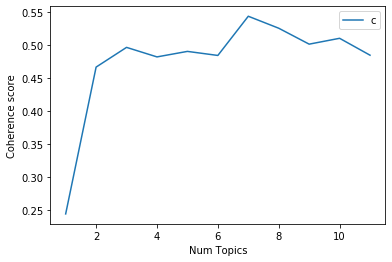

In [29]:
# Visualizamos el resultado del valor de la coherencia por cada topic
# de manera que el topic con mayor coherencia es el valor óptimo para el modelo
x = range(start_, end_, step_)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [30]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " con Coherence Score: ", round(cv, 4))

Num Topics = 1  con Coherence Score:  0.2448
Num Topics = 2  con Coherence Score:  0.4671
Num Topics = 3  con Coherence Score:  0.497
Num Topics = 4  con Coherence Score:  0.4826
Num Topics = 5  con Coherence Score:  0.4909
Num Topics = 6  con Coherence Score:  0.4848
Num Topics = 7  con Coherence Score:  0.5442
Num Topics = 8  con Coherence Score:  0.526
Num Topics = 9  con Coherence Score:  0.5019
Num Topics = 10  con Coherence Score:  0.5108
Num Topics = 11  con Coherence Score:  0.4852


    Según estos resultados, el óptimo num_topics es 7 con mayor Coherence Score a 0.5442.

In [31]:
# Modelo LDA de gensim con el nº óptimo de topics seleccionados (num_topics a 7 con la posición 6)
num_topics = 7
optimal_model_id = 6

# Modelo con el óptimo nº de topics teniendo en cuenta la posición
optimal_model = model_list[optimal_model_id]

In [32]:
# Get a representation for selected topics
optimal_model.show_topics(num_topics)

[(0,
  '0.031*"album" + 0.015*"beat" + 0.012*"song" + 0.011*"bolt" + 0.010*"track" + 0.007*"yard" + 0.006*"game" + 0.006*"money" + 0.005*"know" + 0.005*"come"'),
 (1,
  '0.165*"quot" + 0.010*"stitch" + 0.009*"wallet" + 0.007*"comfy" + 0.007*"sore" + 0.005*"bench" + 0.005*"tori" + 0.005*"shorts" + 0.005*"bath" + 0.004*"skirt"'),
 (2,
  '0.014*"knife" + 0.013*"work" + 0.009*"blade" + 0.009*"battery" + 0.009*"easy" + 0.008*"light" + 0.008*"product" + 0.007*"handle" + 0.007*"clean" + 0.006*"need"'),
 (3,
  '0.052*"album" + 0.043*"song" + 0.017*"music" + 0.015*"sound" + 0.014*"track" + 0.011*"love" + 0.010*"rock" + 0.009*"listen" + 0.008*"record" + 0.007*"band"'),
 (4,
  '0.015*"look" + 0.012*"size" + 0.011*"small" + 0.010*"wear" + 0.009*"price" + 0.009*"work" + 0.009*"nice" + 0.008*"quality" + 0.008*"order" + 0.007*"purchase"'),
 (5,
  '0.010*"think" + 0.009*"thing" + 0.009*"feel" + 0.009*"know" + 0.008*"work" + 0.007*"come" + 0.006*"year" + 0.006*"people" + 0.006*"start" + 0.006*"conjurer

In [33]:
# Conversión en pandas y muestra por topics las palabras o términos con mayor importancia
word_dict = {};
for i in range(num_topics):
    words = optimal_model.show_topic(i, topn = 20)
    word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07
0,album,quot,knife,album,look,think,product
1,beat,stitch,work,song,size,thing,bottle
2,song,wallet,blade,music,small,feel,taste
3,bolt,comfy,battery,sound,wear,know,smell
4,track,sore,easy,track,price,work,water
5,yard,bench,light,love,work,come,supplement
6,game,tori,product,rock,nice,year,help
7,money,shorts,handle,listen,quality,people,pill
8,know,bath,clean,record,order,start,drink
9,come,skirt,need,band,purchase,conjurer,vitamin


In [34]:
# Visualizamos las primeras palabras clave de cada topic (ahora en horizontal) junto al peso o valor de importancia
topics = optimal_model.print_topics(num_topics=-1, num_words=5)
t = []
for topic in topics:
    t.append(topic[1].split("+"))

sent_topics_df = pd.DataFrame(data=t,columns=["word1","word2","word3","word4","word5"])
sent_topics_df

,word1,word2,word3,word4,word5
0,"0.031*""album""","0.015*""beat""","0.012*""song""","0.011*""bolt""","0.010*""track"""
1,"0.165*""quot""","0.010*""stitch""","0.009*""wallet""","0.007*""comfy""","0.007*""sore"""
2,"0.014*""knife""","0.013*""work""","0.009*""blade""","0.009*""battery""","0.009*""easy"""
3,"0.052*""album""","0.043*""song""","0.017*""music""","0.015*""sound""","0.014*""track"""
4,"0.015*""look""","0.012*""size""","0.011*""small""","0.010*""wear""","0.009*""price"""
5,"0.010*""think""","0.009*""thing""","0.009*""feel""","0.009*""know""","0.008*""work"""
6,"0.035*""product""","0.019*""bottle""","0.014*""taste""","0.013*""smell""","0.012*""water"""


    Topic 1 - reviews con palabras relacionadas con la música y al mismo tiempo relacionado con el deporte 
        {album, song, track, eminem, production, listen} y {beat, bolt, track, yard, game, ...}
        
    Topic 2 - es algo confuso porque algunas palabras referencian la música (collins, alice), otros hacen referencia a la ropa (shorts, skirt) y para el resto de palabras no identifico ningún topic.
    
    Topic 3 - reviews relacionados con productos para el cuidado personal 
        {knife, product, blade, battery, light, product, handle, clean, need, ..., water}
 
    Topic 4 - reviews relacionados con la música, canciones, álbumes, bandas musicales, instrumentos, y tipos de música
       {album, song, music, sound, track, love, rock, listen, record, band, release, guitar, voice, lyric, version, single, classic}
          
    Topic 5 - reviews relacionados con consejos o hábitos saludables y productos para el cuidado personal 
        {look, size, wear, price, work, nice, quality, product, think, want, feel, love, need, recommend, bike}
    
    Topic 6 - con estas palabras no identifico un topic
          
    Topic 7 - reviews relacionados con la hábitos saludables en la comida y cuidado personal, y cuidados médicos y puede que en el deporte
        {product, bottle, taste, smell, water, supplement, help, pill, drink, vitamin, flavor, food, weight, protein, body, skin, health, fish}


Con lo cual, según este análisis de los 7 topics, sólo encuento con sentido en 6 topics pero en muchos las palabras referencias distintos temas: 
    
    Topic 1 - música y deporte
    Topic 2 - música y moda
    Topic 3 - cuidado personal
    Topic 4 - música (canciones, álbum, bandas, instrumentos y tipos)
    Topic 5 - cuidado personal (hábitos saludables)
    Topic 7 - hábitos saludables comida/deporte y cuidados médicos 

### Calidad del modelo

#### Perplexity y Coherence Score 

In [35]:
# Perplexity # Medida de qué tan bueno es el modelo. Cuanto más bajo, mejor
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  

# Coherence Score del id del óptimo num_topics seleccionadoeste dato ya esta calculado en los apartados anteriores)
print('\nCoherence Score: ', coherence_values[optimal_model_id])


Perplexity:  -8.308602364786303

Coherence Score:  0.5441602634457833


### Visualización del modelo

In [36]:
# Enable the automatic display of visualizations in the IPython Notebook.
pyLDAvis.enable_notebook()
# Transforms the Gensim TopicModel and related corpus and dictionary into the data structures needed for the visualization
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.211433 -0.079708       1        1  27.383181
5     -0.107036 -0.106727       2        1  26.255835
3      0.179102 -0.173612       3        1  17.341784
2     -0.220689  0.013576       4        1  12.993918
6     -0.068447  0.281581       5        1   6.692069
0      0.172941 -0.102919       6        1   6.516004
1      0.255563  0.167810       7        1   2.817205, topic_info=      Category         Freq          Term        Total  loglift  logprob
47     Default  3723.000000          quot  3723.000000  30.0000  30.0000
0      Default  8776.000000         album  8776.000000  29.0000  29.0000
126    Default  6614.000000          song  6614.000000  28.0000  28.0000
2661   Default  4203.000000       product  4203.000000  27.0000  27.0000
40     Default  2428.000000         music  2428.000000  26.0000  26.0000
201    Default  2693.000000         track  2693.000000  25.0000  25.0000
10354  Default  2521.000000          size  2521.000000  24.0000  24.0000
521    Default  2450.000000         small  2450.000000  23.0000  23.0000
392    Default  3706.000000          look  3706.000000  22.0000  22.0000
151    Default  2746.000000         sound  2746.000000  21.0000  21.0000
1472   Default  1424.000000         knife  1424.000000  20.0000  20.0000
87     Default  2177.000000          wear  2177.000000  19.0000  19.0000
6221   Default   992.000000        bottle   992.000000  18.0000  18.0000
376    Default  1169.000000          beat  1169.000000  17.0000  17.0000
245    Default  1508.000000          rock  1508.000000  16.0000  16.0000
195    Default  5373.000000          work  5373.000000  15.0000  15.0000
66     Default  1340.000000         water  1340.000000  14.0000  14.0000
2412   Default   836.000000         taste   836.000000  13.0000  13.0000
116    Default  1654.000000         order  1654.000000  12.0000  12.0000
32     Default  1484.000000        listen  1484.000000  11.0000  11.0000
1873   Default  2281.000000         price  2281.000000  10.0000  10.0000
4096   Default   962.000000         blade   962.000000   9.0000   9.0000
1121   Default  1582.000000      purchase  1582.000000   8.0000   8.0000
12578  Default   909.000000       battery   909.000000   7.0000   7.0000
3456   Default   679.000000         smell   679.000000   6.0000   6.0000
829    Default  1763.000000          easy  1763.000000   5.0000   5.0000
3969   Default  1322.000000         large  1322.000000   4.0000   4.0000
35     Default  3488.000000          love  3488.000000   3.0000   3.0000
1789   Default  2011.000000         light  2011.000000   2.0000   2.0000
51     Default  1251.000000        record  1251.000000   1.0000   1.0000
10354   Topic1  2519.877441          size  2521.069336   1.2948  -4.4638
521     Topic1  2448.896484         small  2450.092529   1.2948  -4.4924
87      Topic1  2176.306885          wear  2177.499023   1.2947  -4.6104
116     Topic1  1653.319702         order  1654.513062   1.2945  -4.8853
3969    Topic1  1321.196289         large  1322.390137   1.2943  -5.1095
28277   Topic1  1188.480347          bike  1189.673828   1.2942  -5.2154
4732    Topic1  1045.480835   comfortable  1046.672729   1.2941  -5.3436
3239    Topic1  1020.312073          item  1021.505371   1.2941  -5.3679
7604    Topic1   838.806763          shoe   839.997986   1.2938  -5.5638
71      Topic1   812.616455         color   813.809021   1.2938  -5.5955
4998    Topic1   802.874268          foot   804.067078   1.2938  -5.6076
2554    Topic1   762.226318         strap   763.418335   1.2937  -5.6596
25001   Topic1   733.022034         shave   734.218872   1.2936  -5.6986
1746    Topic1   495.910522         shirt   497.102356   1.2928  -6.0894
377     Topic1   431.532166          belt   432.725647   1.2925  -6.2285
12576   Topic1   409.977478         scent   411.177856   1.2923  -6.2797
27614   Topic1   401.024506       instal

In [37]:
pyLDAvis.save_html(vis, '../notebooks/results/topics_reviewsamazon_n7completo.html')

Cada burbuja en la parte izquierda representa un topic. 

Cuanto más grande la burbuja, más predominante es ese topic. En nuestra representación y según el apartado final "Distribución de topics en el corpus", los topics con menor distribución son los nº 1 y 2 que están asociados a las burbujas 6 (6.5%) y 7 (2.8%) respectivamente y que efectivamente su tamaño es menor por ejemplo con respecto a las burbujas 1 (27.4%) y 2 (26.3%) que referencian los topics 5 y 6 respectivamente.

Mapeo entre burbujas y topics:

    Burbuja 1  representa el Topic nº 5  (reviews cuidado personal (hábitos saludables))
    Burbuja 2  representa el Topic nº 6 
    Burbuja 3  representa el Topic nº 4  (reviews sobre música (canciones, álbum, bandas, instrumentos y tipos)
    Burbuja 4  representa el Topic nº 3  (reviews cuidado personal)
    Burbuja 5  representa el Topic nº 7  (reviews sobre hábitos saludables comida/deporte y cuidados médicos)
    Burbuja 6  representa el Topic nº 1  (reviews sobre música y deporte)
    Burbuja 7  representa el Topic nº 2  (reviews sobre música y moda)


Si posicionamos el cursor sobre una burbuja, las palabras y el gráfico de la derecha se actualizan y estas palabras son las palabras clave más importantes para el topic asociado a dicha burbuja.

Si seleccionamos una palabra del gráfico de barras, observamos las burbujas en las cuales aparece por orden de importancia según el tamaño de la(s) burbuja(s), Por ejemplo si seleccionamos la palabra work en la burbuja 1 vemos que también se encuentra en las burbujas 2, 4 y 5 cuyos topics están relacionados con el topic de los hábitos saludables.

Algunas burbujas que se solapan como las nº 6 y 3,  y algunas otras como las nº 1, 2 y 4, todas ellas porque comparten las mismas palabras.

### Topic dominante por texto

In [38]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num+1), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [39]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=processed_texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.5778,"album, song, music, sound, track, love, rock, ...","[tumbleweed, connection, raise, elton, initial..."
1,1,5.0,0.3024,"look, size, small, wear, price, work, nice, qu...","[gonna, review, trendy, thug, wear, rainbow, c..."
2,2,4.0,0.3270,"album, song, music, sound, track, love, rock, ...","[album, lyric, site, lyric, song, absolution, ..."
3,3,1.0,0.6182,"album, beat, song, bolt, track, yard, game, mo...","[poorly, horrible, album, reason, snoop, retir..."
4,4,1.0,0.7049,"album, beat, song, bolt, track, yard, game, mo...","[album, disappointment, live, hype, like, said..."
5,5,6.0,0.4989,"think, thing, feel, know, work, come, year, pe...","[huge, song, good, song, good, arint, good, pl..."
6,6,5.0,0.4430,"look, size, small, wear, price, work, nice, qu...","[album, gift, thank, goodness, cause, track, a..."
7,7,2.0,0.3955,"quot, stitch, wallet, comfy, sore, bench, tori...","[know, like, alanis, morrisette, exception, qu..."
8,8,6.0,0.4995,"think, thing, feel, know, work, come, year, pe...","[dynamic, people, time, secret, message, armch..."
9,9,4.0,0.5098,"album, song, music, sound, track, love, rock, ...","[possible, lucky, albums, consciously, decide,..."


    Ninguno de estos documentos referencian los topics 3 y 7 (cuidado personal / habitos saludables y cuidados médicos)
    Para el documento nº 3, 4, 10, 12, 15, 17 y 19 --> topic dominante es el nº 1 (reviews sobre  música y deporte), con mayor % en Doc.nº 17 0.7685
    Para el documento nº 7 --> topic dominante es el nº 2 con reviews de música y moda
    Para el documento nº 0, 2, 9, 13 y 18 --> topic dominante es el nº 4 reviews de música (canciones, álbum, bandas, instrumentos y tipos)

### Documento más representativo por topic

In [40]:
sent_topics_sorteddf_lda = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_lda = pd.concat([
        sent_topics_sorteddf_lda,
        grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
        axis=0)

# Reset Index    
sent_topics_sorteddf_lda.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_lda.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_lda

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1.0,0.9564,"album, beat, song, bolt, track, yard, game, mo...","[hell, like, eminem, sucker, know, tupac, stan..."
1,2.0,0.9620,"quot, stitch, wallet, comfy, sore, bench, tori...","[bien, cierto, notum, bastante, aacute, oacute..."
2,3.0,0.8906,"knife, work, blade, battery, easy, light, prod...","[simple, effective, site, tool, easy, site, ad..."
3,4.0,0.9216,"album, song, music, sound, track, love, rock, ...","[rings, world, album, style, time, start, cohe..."
4,5.0,0.9771,"look, size, small, wear, price, work, nice, qu...","[woman, hourglass, figure, wear, typically, si..."
5,6.0,0.9216,"think, thing, feel, know, work, come, year, pe...","[think, kava, kava, extract, okay, valerian, n..."
6,7.0,0.8623,"product, bottle, taste, smell, water, suppleme...","[flavor, stevia, drops, chocolate, toffee, van..."


### Distribución de topics en el corpus

In [41]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), num_topics)
df_topic_contribution = pd.DataFrame({'topic': topic_contribution.index, 'contribution': topic_contribution})
df_topic_contribution.reset_index(drop=True, inplace=True)

# Show
df_topic_contribution

,topic,contribution
0,5.0,0.49935
1,6.0,0.14775
2,3.0,0.12145
3,4.0,0.10645
4,7.0,0.06580
5,1.0,0.05340
6,2.0,0.00580


### Conclusiones


A partir de un dataset completo de reviews se ha aplicado la técnica topic modeling para la detección de los principales topics o temas, a los cuales referencian los usuarios desde la red y cuya interpretabilidad puede ser algo confusa ya que observamos que las palabras incluidas en un topic referencias a temas diferentes:

  - Topics 1, 2 y 4 referencian a reviews del topic música y todo lo asociado (canciones, álbumes, bandas, instrumentos y sus tipos)
  - Topic 1 también referencia al deporte
  - Topic 2 además referencia a la moda (clothes)
  - Topics 3, 5 y 7 referencias a reviews relacionadas con el cuidado personal (hábitos saludables comida/deporte)
    
Y teniendo en cuenta que conocemos la referencia de los subsets incluidos en el dataframe (digital music, clothing, shoes and jewelry, health and personal care y finalmente sports and outdoors)